#Sentiment Analysis

#### Dataset: Customer Reviews on Mobile phones sold in Amazon

**This Notebook explores the customer reviews of popular mobile phone brands. The objective is to explore the dataset, and classify whether a review is positive, negative or neutral using a labelled dataset.**

In [2]:
import warnings
warnings.filterwarnings('ignore')
#-------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
from sklearn.naive_bayes import GaussianNB
#-------------------------------------------------------------------------
import re
import string
import spacy
# from spacy_langdetect import LanguageDetector
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from nltk import word_tokenize
#-------------------------------------------------------------------------
import joblib
import random
random.seed(123)
import math
#-------------------------------------------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers, losses
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
plt.style.use('ggplot')
# sns.set(color_codes=True, style='darkgrid')

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [67]:
# pip install spacy-langdetect

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Initializing the language Model

In [70]:
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

### Data Reading add EDA 

In [4]:
product_data = pd.read_csv('/content/drive/MyDrive/datasets/NLP Project RA Academy/product_data.csv')
reviews_data = pd.read_csv('/content/drive/MyDrive/datasets/NLP Project RA Academy/reviews.csv')

In [4]:
product_data.head()

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.00,0.0
1,B0009N5L7K,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,3.0,https://www.amazon.com/product-reviews/B0009N5L7K,7,49.95,0.0
2,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,https://www.amazon.com/MOTOROLA-C168i-CINGULAR...,https://m.media-amazon.com/images/I/71b+q3ydkI...,2.7,https://www.amazon.com/product-reviews/B000SKTZ0S,22,99.99,0.0
3,B001AO4OUC,Motorola,Motorola i335 Cell Phone Boost Mobile,https://www.amazon.com/Motorola-i335-Phone-Boo...,https://m.media-amazon.com/images/I/710UO8gdT+...,3.3,https://www.amazon.com/product-reviews/B001AO4OUC,21,0.00,0.0
4,B001DCJAJG,Motorola,Motorola V365 no contract cellular phone AT&T,https://www.amazon.com/Motorola-V365-contract-...,https://m.media-amazon.com/images/I/61LYNCVrrK...,3.1,https://www.amazon.com/product-reviews/B001DCJAJG,12,149.99,0.0


In [5]:
product_data.isnull().sum()

asin             0
brand            4
title            0
url              0
image            0
rating           0
reviewUrl        0
totalReviews     0
price            0
originalPrice    0
dtype: int64

In [ ]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   asin           720 non-null    object 
 1   brand          716 non-null    object 
 2   title          720 non-null    object 
 3   url            720 non-null    object 
 4   image          720 non-null    object 
 5   rating         720 non-null    float64
 6   reviewUrl      720 non-null    object 
 7   totalReviews   720 non-null    int64  
 8   price          720 non-null    float64
 9   originalPrice  720 non-null    float64
dtypes: float64(3), int64(1), object(6)
memory usage: 56.4+ KB


In [ ]:
product_data.shape

(720, 10)

In [ ]:
reviews_data.head()

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


In [53]:
reviews_data.isnull().sum()

asin                0
name                2
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64

In [ ]:
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67986 entries, 0 to 67985
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   asin          67986 non-null  object 
 1   name          67984 non-null  object 
 2   rating        67986 non-null  int64  
 3   date          67986 non-null  object 
 4   verified      67986 non-null  bool   
 5   title         67972 non-null  object 
 6   body          67965 non-null  object 
 7   helpfulVotes  27215 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(5)
memory usage: 3.7+ MB


In [ ]:
reviews_data.shape

(67986, 8)

**Dropping unnecessary columns from both df**

In [5]:
product_data.drop(['url', 'title', 'image', 'reviewUrl', 'totalReviews', 'originalPrice'],axis=1, inplace=True)
reviews_data.drop(['name', 'date', 'verified', 'helpfulVotes'], axis=1, inplace=True)

**Removing Null values**

In [ ]:
# product_data.dropna(inplace=True)
# reviews_data.dropna(inplace=True)

In [ ]:
# print("product_data", product_data.shape, "Null Values:",product_data.isnull().sum().sum())
# print("reviews_data", reviews_data.shape, "Null Values:",reviews_data.isnull().sum().sum())

product_data (716, 4) Null Values: 0
reviews_data (67956, 4) Null Values: 0


In [6]:
product_data.rename({'rating':'overall_rating'}, axis=1, inplace=True)

**Joining 2 dataframes**

In [7]:
data = reviews_data.merge(product_data, how='left', on='asin')
data.head()

,asin,rating,title,body,brand,overall_rating,price
0,B0000SX2UC,3,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,NaN,3.0,0.0
1,B0000SX2UC,1,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,NaN,3.0,0.0
2,B0000SX2UC,5,Love This Phone,"This is a great, reliable phone. I also purcha...",NaN,3.0,0.0
3,B0000SX2UC,3,"Love the Phone, BUT...!","I love the phone and all, because I really did...",NaN,3.0,0.0
4,B0000SX2UC,4,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,NaN,3.0,0.0


In [57]:
data.isnull().sum()

asin                0
rating              0
title              14
body               21
brand             200
overall_rating      0
price               0
dtype: int64

In [58]:
data.shape

(67986, 7)

In [8]:
data.title.fillna("No title", inplace=True)
data.brand.fillna("unknown brand", inplace=True)

data.dropna(inplace=True)
data.isnull().sum()

asin              0
rating            0
title             0
body              0
brand             0
overall_rating    0
price             0
dtype: int64

#### Exploring Rating

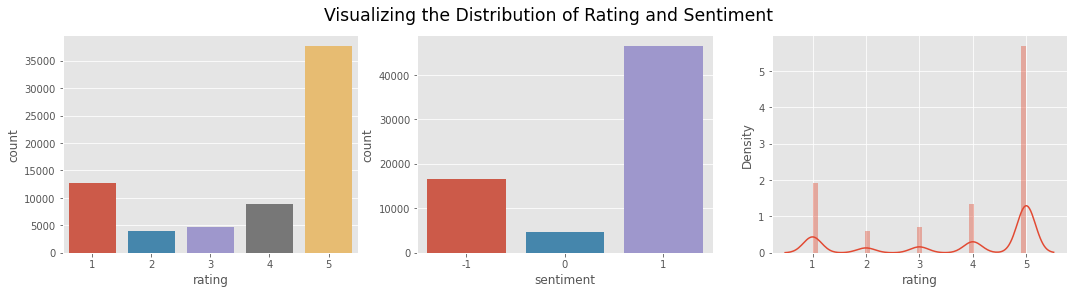

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
sns.countplot(data.rating, ax=ax1)
sns.countplot(data.sentiment, ax=ax2)
sns.distplot(data.rating, ax=ax3);
f.suptitle('Visualizing the Distribution of Rating and Sentiment', fontsize='xx-large');

- The overall -ve ratings seems to be less than the positive ratings.
- This has resulted in an imbalanced dataset.
- Even after clubbing 1 and 2 as -1, the number of positive ratings seems to be much higher compared to the -ve ratings. This is boosted because of combining 4 and 5 as 1. 
- Neutral sentiment seems to be the class with least number of rows.

In [ ]:
pd.value_counts(data.rating)

5    37741
1    12738
4     8821
3     4752
2     3913
Name: rating, dtype: int64

In [ ]:
data.rating.describe()

count    67965.000000
mean         3.807975
std          1.582864
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

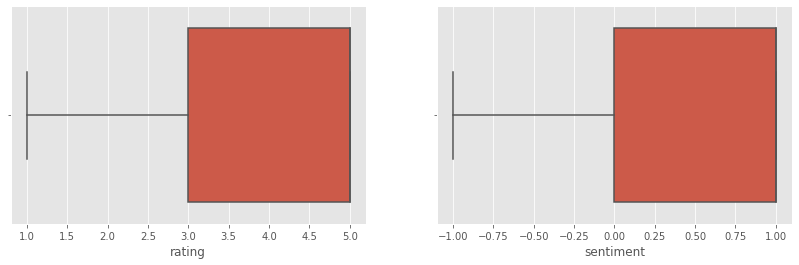

In [ ]:
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
sns.boxplot(data.rating, ax=ax1);
sns.boxplot(data.sentiment, ax=ax2);

- low ratings occupy a space less than the first quartile.
- The bulk of the data is for ratings 4 and 5.
- This requires downsampling. The number of positive ratings can be significantly reduced to match the number of -ve sentiments.  

In [ ]:
data.rating.mode()

0    5
dtype: int64

## Data Cleaning and Text Analytics

In [ ]:
data.sample(25).body

28768                                        As advertised
7042                 Phone was for my mother, she loves it
48207                                          Great phone
6820                                             very good
6542                         El artículo llegó muy arañado
42774                At a hair over $200, this is a steal.
59298            Couldn't ask for more at this price point
5537     EVERYONE SEEMS TO LOVE THEIR S4, BUT LIKE EVER...
50148                          I love everything about it!
32158    It's a great phone with an outstanding battery...
60082    The smartphone is fascinating, always I was lo...
45447                                             Its nice
18572    This phone was great for my mother as I battle...
2849     Phone is designed for At&T only, does not take...
34725                                            Five Star
22436                except samsung pay everything is good
832      Great basic phone. Love the metal attached cli.

**Observations:**

- There are price tags and model numbers
- There are non-english words
- There are -ve slang words used
- There are emojies

In [ ]:
print(data.body[65913],'\n\n',
data.body[55249],'\n\n',
data.body[58098],'\n\n',
data.body[63168],'\n\n',
data.body[9119])

Muy bueno pero esperaba que venga con audifonos 

 El celu a los dos días se m bloqueó 

 Venía desbloqueado de fábrica, por lo que se conectó sin problemas.. Hasta hora funciona perfectamente 

 Fast, reliable, and everything a $150 phone should be. Also gave me the freedom to choose the most affordable cell phone service that works best for me, plus I'm not locked into a contract. Take that, big cell phone carriers! 

 I started out looking at $90 phones to use with a non-contract service and came across this wonderful phone. It does everything I need (I have a great desk computer to use for the internet) and the sound is excellent, especially for my hard of hearing condition. I had heard it had a very good battery and after I charged it fully I waited a week, and even with regular use the battery was still fine. I finally gave out at 10 days and charged it again, I don't know how much longer it would have lasted. Way to go! Pat Powers


In [9]:
stop_words = stopwords.words('english')

#### Funtion to clean text of non-alphanumeric characters, punctuations, stop words, non-english sentennces, and to lemmatize it

- returns lemmatized sentence with stop words removed
- returns NaN for non english reviews

In [ ]:
def clean_text(test_series):
    for text in test_series:
        #remove escape characters
        text = str(text).lower()
        text = re.sub('(\\t)', ' ', text)
        text = re.sub('(\\n)', ' ', text)
        text = re.sub('(\\r)', ' ', text)

        #replace punctuations with space
        text = re.sub(r'[%s]'%(string.punctuation.replace("%", "").replace(".", "")), '', text)

        #replacing non alphabetic characters
        text = re.sub(r'[^A-Za-z0-9\s]', '', text)
        
        #remove 2 consequtive dots
        text = re.sub("(\.\.+)", '', text)
        
        #remove 2 consequtive - & _
        text = re.sub("(\-\-+)", '', text)
        text = re.sub("(\_\_+)", '', text)

        #remove multiple spaces
        text = re.sub("(\s+)",' ',text)

        #####using spacy to remove non-english words, stopwords, and for lemmatization
        doc = nlp(str(text))
        if doc._.language['language'] in ['en', 'no']:
            text = [str(token.lemma_) for token in doc if token.text not in stop_words]
            text = " ".join(text)
            ##remove space from start and end
            text = text.strip()
        else:
            text = np.nan
        yield text

**function check:**

In [ ]:
print(list(clean_text([" I started out looking at $90 phones to use with a non-contract service and came across this wonderful phone. It does everything I need (I have a great desk computer to use for the internet) and the sound is excellent, especially for my hard of hearing condition."])))
print(list(clean_text(["Venía desbloqueado de fábrica, por lo que se conectó sin problemas.. Hasta hora funciona perfectamente"])))
print(list(clean_text(["Amo el Celular, excelente rendimiento, excelente relación precio calidad. No le pide favores a otras marcas de celulares con modelos de similares características."])))

['start look 90 phone use noncontract service come across wonderful phone everything need great desk computer use internet sound excellent especially hard hear condition']
[nan]
[nan]


In [ ]:
list(clean_text([" I started out looking at $90 phones to use with a non-contract service and came across this wonderful phone. It does everything I need (I have a great desk computer to use for the internet) and the sound is excellent, especially for my hard of hearing condition."]))[0]

'start look 90 phone use noncontract service come across wonderful phone everything need great desk computer use internet sound excellent especially hard hear condition'

In [ ]:
# %%time
# clean_reviews_generator = [doc for doc in clean_text(data['body'].to_list())]

CPU times: user 21min 22s, sys: 8.63 s, total: 21min 31s
Wall time: 21min 29s


In [ ]:
# joblib.dump(clean_reviews_generator, '/content/drive/MyDrive/datasets/NLP Project RA Academy/cleaned_reviews_.pkl')

['/content/drive/MyDrive/datasets/NLP Project RA Academy/cleaned_reviews_.pkl']

In [10]:
clean_reviews_generator = joblib.load('/content/drive/MyDrive/datasets/NLP Project RA Academy/cleaned_reviews_.pkl')

In [11]:
data['çlean_reviews'] = clean_reviews_generator

In [12]:
data['sentiment'] = data.rating.apply(lambda x: 1 if x > 3 else 0 if x == 3 else -1)

In [15]:
neg_reviews = [review.split(" ") for review in data[data.sentiment == -1].body.to_list()]
neg_reviews_words = [word for sent in neg_reviews for word in sent if word.lower() not in stop_words]

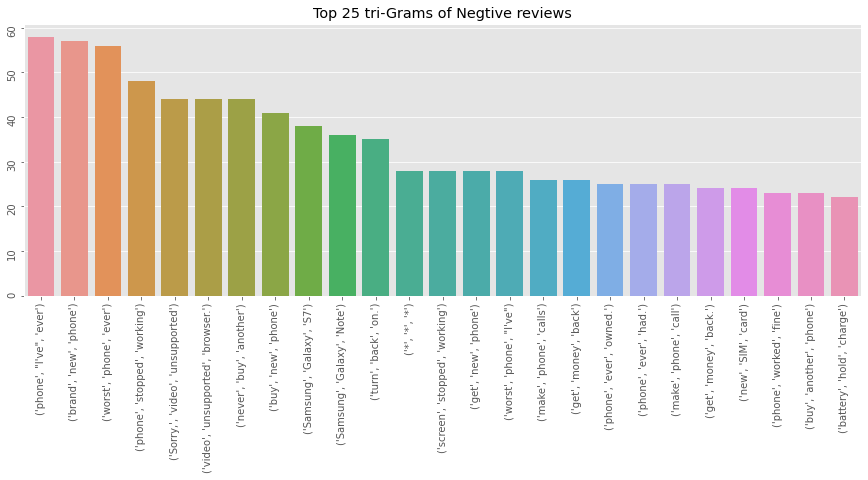

In [16]:
neg_trigrams = pd.value_counts(list(ngrams(neg_reviews_words, 3))).sort_values(ascending=False)[:25]
plt.figure(figsize=(15,5))
ax = plt.gca()
plt.title("Top 25 tri-Grams of Negtive reviews")
sns.barplot(neg_trigrams.index, neg_trigrams, ax=ax)
ax.tick_params(rotation=90);

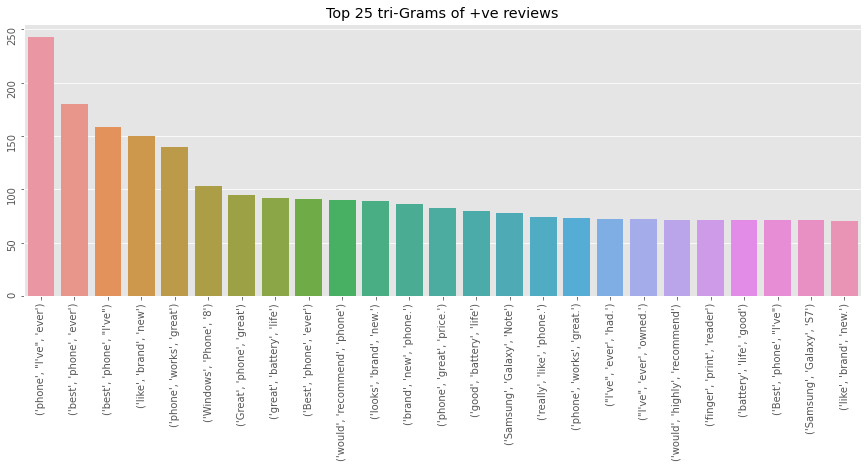

In [ ]:
pos_reviews = [review.split(" ") for review in data[data.sentiment == 1].body.to_list()]
pos_reviews_words = [word for sent in pos_reviews for word in sent if word.lower() not in stop_words]

pos_trigrams = pd.value_counts(list(ngrams(pos_reviews_words, 3))).sort_values(ascending=False)[:25]
plt.figure(figsize=(15,5))
ax = plt.gca()
plt.title("Top 25 tri-Grams of +ve reviews")
sns.barplot(pos_trigrams.index, pos_trigrams, ax=ax)
ax.tick_params(rotation=90);

#### Exploring Brand

In [ ]:
pd.value_counts(data.brand)

Samsung          33612
Motorola          8879
Nokia             5914
Apple             5145
Xiaomi            4411
Google            3786
Sony              3195
HUAWEI            2225
OnePlus            347
ASUS               251
unknown brand      200
Name: brand, dtype: int64

- This dataset appears to be a dataset of phones from the ngrams and brand names

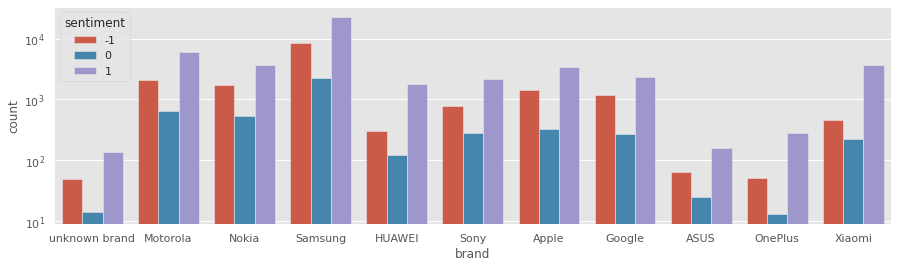

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(data.brand, hue=data.sentiment)
g.set_yscale('log');

#### Removing all Non-english reviews

In [64]:
data.isnull().sum()

asin                 0
rating               0
title                0
body                 0
brand                0
overall_rating       0
price                0
çlean_reviews     9274
sentiment            0
dtype: int64

In [ ]:
pd.value_counts(data[data.çlean_reviews.isna()]['sentiment'])

 1    7923
-1    1062
 0     289
Name: sentiment, dtype: int64

In [ ]:
pd.value_counts(data['sentiment'])

 1    46562
-1    16651
 0     4752
Name: sentiment, dtype: int64

In [13]:
data.dropna(inplace=True)

### Downsampling

In [14]:
data_rest = data[data.sentiment != 1].copy(deep=True).reset_index(drop=True)
data_pos = data[data.sentiment == 1]

In [15]:
print(data_rest.shape)
print(data_pos.shape)
tot_pos_rows = data_pos.shape[0]

(20052, 9)
(38639, 9)


In [16]:
pos_downsampled = data_pos.sample(math.floor(tot_pos_rows*0.4)).reset_index(drop=True)

In [17]:
data_downsampled = pd.concat([pos_downsampled, data_rest], axis=0)

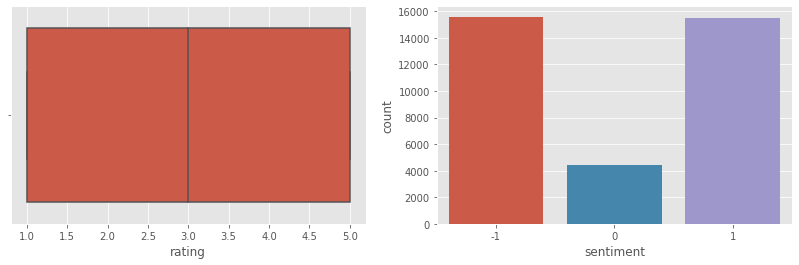

In [18]:
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
sns.boxplot(data_downsampled.rating, ax=ax1);
sns.countplot(data_downsampled.sentiment, ax=ax2);

 - The +ve and -ve classes in the data appears to have been balanced.
 - But the neutral class is still a minority

**Freeing the memory of all unwanted datasets and variables**

In [19]:
del pos_downsampled, tot_pos_rows, data_pos, data_rest, data, product_data, reviews_data

In [20]:
data_downsampled = data_downsampled[['çlean_reviews', 'sentiment']].copy(deep=True)

**Cleaned Data == data_downsampled**

In [21]:
data_downsampled.head()

,çlean_reviews,sentiment
0,good phone price would recommend buy,1
1,perfect order good new without price tag,1
2,buy phone mobile deal amazon new state come se...,1
3,not wish spend much money cell phone home dead...,1
4,phone look great,1


## Model_1 -> TFIDF + Naieve Bayes Classifier

In [ ]:
# tfidf_vocab = []
# for review in data_downsampled.çlean_reviews:
#     for word in review.split(" "):
#         tfidf_vocab.append(word)
# tfidf_vocab = set(tfidf_vocab)
# print("TFIDF Vocab size:", len(tfidf_vocab))

TFIDF Vocab size: 27927


In [ ]:
def tokenize(text):
    words = [word for word in text.split(" ") if word not in stop_words]
    return words

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=stop_words, tokenizer=tokenize)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data_downsampled.çlean_reviews, data_downsampled.sentiment, test_size=0.2, random_state=123)

In [ ]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#### Feature selection using sklearn's SelectPercentile

In [ ]:
fselector = SelectPercentile(f_classif, percentile=10)
fselector.fit(X_train_vec, y_train)

selected_train = fselector.transform(X_train_vec).toarray()
selected_test = fselector.transform(X_test_vec).toarray()

In [ ]:
selected_train.shape

(28405, 2496)

In [ ]:
nb_model = GaussianNB()

In [ ]:
%%time
nb_model.fit(selected_train, y_train)

CPU times: user 832 ms, sys: 5.29 ms, total: 838 ms
Wall time: 848 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
print("Train Score:", nb_model.score(selected_train, y_train))
print("Test Score:", nb_model.score(selected_test, y_test))

Train Score: 0.7350114416475972
Test Score: 0.6706561531962827


## Model_2 -> TFIDF + Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree_model = DecisionTreeClassifier()

In [ ]:
%%time
dtree_model.fit(selected_train, y_train)

CPU times: user 27.5 s, sys: 9.65 ms, total: 27.5 s
Wall time: 27.4 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
print("Train Score:", dtree_model.score(selected_train, y_train))
print("Test Score:", dtree_model.score(selected_test, y_test))

Train Score: 0.9952473156134484
Test Score: 0.67319065052098


In [ ]:
res = dtree_model.cost_complexity_pruning_path(selected_train, y_train)

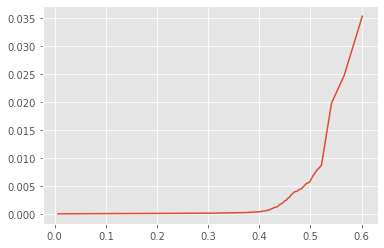

In [ ]:
sns.lineplot(y=res['ccp_alphas'], x=res['impurities']);

In [ ]:
%%time
kfold = KFold(n_splits=10, random_state=123)
dtree_model = DecisionTreeClassifier(ccp_alpha=0.01, random_state=123, min_samples_leaf=20)
results = cross_val_score(dtree_model, selected_train, y_train, cv=kfold)

print(results)
print(f"Mean Accuracy: {results.mean()*100}\nStandard Deviation: {results.std()*100}")

[0.61633228 0.62442802 0.61422034 0.60999648 0.62090813 0.63309859
 0.61338028 0.60528169 0.61408451 0.62464789]
Mean Accuracy: 61.76378209418425
Standard Deviation: 0.7747118758127477
CPU times: user 5min 9s, sys: 402 ms, total: 5min 9s
Wall time: 5min 7s


In [ ]:
print("Train Score:", dtree_model.score(selected_train, y_train))
print("Test Score:", dtree_model.score(selected_test, y_test))

Train Score: 0.6206301707445873
Test Score: 0.6239087580963109


--------

## Mode_3 DistilBERT from HuggingFace Transformers

In [23]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 6.5 MB/s 
     |████████████████████████████████| 895 kB 69.1 MB/s 
     |████████████████████████████████| 636 kB 68.8 MB/s 
     |████████████████████████████████| 3.3 MB 58.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [24]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainingArguments, TFTrainer, TFDistilBertForMultipleChoice

In [25]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [26]:
depth=3
y_train = y_train.apply(lambda x: 2 if x == -1 else x)
# y_train = tf.one_hot(y_train, depth)
y_test = y_test.apply(lambda x: 2 if x == -1 else x)
# y_test = tf.one_hot(y_test, depth)

In [27]:
sample = tokenizer([X_train.iloc[23],X_train.iloc[29]], truncation=True, padding=True)
print(sample['input_ids'],'\n', sample['attention_mask'])

[[101, 2404, 2918, 11899, 8224, 22138, 2310, 21885, 2239, 1018, 2095, 19102, 9088, 3602, 5310, 5454, 3042, 4950, 2664, 8849, 15703, 2518, 3066, 2521, 6420, 11112, 24095, 15703, 4487, 19150, 24095, 2828, 3435, 2191, 3161, 3145, 2604, 15703, 2279, 12117, 12326, 4297, 2239, 8159, 11638, 2811, 2373, 3872, 2051, 3697, 2156, 3898, 16360, 19234, 2192, 17010, 5080, 2093, 2733, 2521, 2428, 3335, 25430, 15457, 12117, 12326, 18392, 24095, 102], [101, 2147, 2307, 2048, 3204, 2434, 3715, 2099, 2644, 3715, 6046, 2367, 3715, 2099, 2224, 28667, 8167, 3351, 6046, 18015, 25416, 3126, 2497, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] 
 [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [28]:
X_train = X_train.to_list()
X_test = X_test.to_list()

In [29]:
encoded_train = tokenizer(X_train, truncation=True, padding=True)
encoded_test = tokenizer(X_test, truncation=True, padding=True)

In [30]:
%%time

tf_train = tf.data.Dataset.from_tensor_slices((
    dict(encoded_train), 
    y_train
))
tf_test = tf.data.Dataset.from_tensor_slices((
    dict(encoded_test), 
    y_test
))

CPU times: user 1min 25s, sys: 774 ms, total: 1min 26s
Wall time: 1min 33s


In [31]:
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [32]:
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(
    tf_train.batch(16), 
    batch_size=16,
    epochs=4
    )

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [39]:
model.save_pretrained('/content/drive/MyDrive/datasets/NLP Project RA Academy/my_model', saved_model=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/datasets/NLP Project RA Academy/my_model/saved_model/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/datasets/NLP Project RA Academy/my_model/saved_model/1/assets


#### Model Evaluation on test set

In [40]:
model.evaluate(
    tf_test.shuffle(len(X_test)).batch(16),
    batch_size=16,
    return_dict=True
)

444/444 [==============================] - 132s 291ms/step - loss: 0.7116 - accuracy: 0.7688


{'accuracy': 0.7687975168228149, 'loss': 0.7116037011146545}

#### Accuracy Report

- Training Accuracy: 92%
- Test Accuracy: 77% 

**Improvements:**

Although the score is bettwe compared to previous models. The model seems to slightly overfit the data. This can further be improved by 1. increasing the number of epochs, 2. training the model for longer batch sizes.  

-----